# Formula 1 - Random Forest Tuning

### Import Relevant Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from tqdm import tqdm
import math
from IPython.display import clear_output

In [3]:
from collections import defaultdict
import regex as re
import datetime

In [4]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.metrics import r2_score
import joblib

# Load The Data

In [5]:
driver_standings = pd.read_csv('./CSV/driver_standings.csv').drop(['Unnamed: 0'], axis=1)

In [6]:
constructor_standings = pd.read_csv('./CSV/constructor_standings.csv').drop(['Unnamed: 0'], axis=1)

In [7]:
main_df = pd.read_csv('./CSV/main_df.csv').drop(['Unnamed: 0'], axis=1)

In [8]:
main_df.head()

,season,round,race_name,name,constructor,grid,qual_position,q_best,q_worst,q_mean,...,circuitId,locality,country,type,direction,length,weather,finish_position,points,filled_splits
0,2014,1,australian,Nico Rosberg,mercedes,3.0,3.0,92.564,104.595,99.807667,...,albert_park,Melbourne,Australia,Street circuit,Clockwise,5.303,"overcast, 19°c (66°f) dry",1.0,25.0,0.000
1,2014,1,australian,Kevin Magnussen,mclaren,4.0,4.0,90.949,105.745,99.980333,...,albert_park,Melbourne,Australia,Street circuit,Clockwise,5.303,"overcast, 19°c (66°f) dry",2.0,18.0,26.777
2,2014,1,australian,Jenson Button,mclaren,10.0,11.0,91.396,104.437,97.916500,...,albert_park,Melbourne,Australia,Street circuit,Clockwise,5.303,"overcast, 19°c (66°f) dry",3.0,15.0,30.027
3,2014,1,australian,Fernando Alonso,ferrari,5.0,5.0,91.388,105.819,100.004000,...,albert_park,Melbourne,Australia,Street circuit,Clockwise,5.303,"overcast, 19°c (66°f) dry",4.0,12.0,35.284
4,2014,1,australian,Valtteri Bottas,williams,15.0,10.0,91.601,108.147,101.200000,...,albert_park,Melbourne,Australia,Street circuit,Clockwise,5.303,"overcast, 19°c (66°f) dry",5.0,10.0,47.639


In [9]:
# age variable committed to csv as datetime type, loaded as a string. Reformat to remove ' days' from instances.

def day_split(age):
    return int(age.split(' ')[0])

main_df.ageDuringRace = main_df.ageDuringRace.apply(day_split)

In [10]:
main_df.dtypes

season               int64
round                int64
race_name           object
name                object
constructor         object
grid               float64
qual_position      float64
q_best             float64
q_worst            float64
q_mean             float64
ageDuringRace        int64
circuitId           object
locality            object
country             object
type                object
direction           object
length             float64
weather             object
finish_position    float64
points             float64
filled_splits      float64
dtype: object

In [11]:
race_dps = []

for years in np.array(main_df.season.unique()):
    race_dps.extend([(years, race_name) if race_name != '70th-anniversary' 
                     else (race_name.split('-')[0], race_name.split('-')[1], years)
                     for race_name in 
                     list(main_df[main_df.season == years]['race_name'].unique())])
    race_dps.extend([(years, 'usa') for race_name in
                 list(main_df[main_df.season == years]['race_name'].unique()) if race_name=='us'])
    race_dps.extend([(years, 'mexico') for race_name in
                 list(main_df[main_df.season == years]['race_name'].unique()) if race_name=='mexican'])

# Model Tuning

### Train-Test Split on pre-2020 to predict 2020 onwards

In [12]:
main = main_df.copy()

train = main[main.season<2020]
test = main[main.season==2020]

r_train = train.pop('finish_position')
y_train = train.pop('filled_splits')
p_train = train.pop('points')
X_train = train
r_test = test.pop('finish_position')
y_test = test.pop('filled_splits')
X_test = test
p_test = test.pop('points')

In [13]:
# Natural Language Processing
cvec_weather = CountVectorizer(stop_words='english', binary=True)#strip_words

# Dummification
ohe_direction = OneHotEncoder(handle_unknown='ignore')
ohe_country = OneHotEncoder(handle_unknown='ignore')
ohe_locality = OneHotEncoder(handle_unknown='ignore')
ohe_type = OneHotEncoder(handle_unknown='ignore')
ohe_season = OneHotEncoder(handle_unknown='ignore')
ohe_round = OneHotEncoder(handle_unknown='ignore')
ohe_qual_pos = OneHotEncoder(handle_unknown='ignore')
ohe_grid_pos = OneHotEncoder(handle_unknown='ignore')
ohe_racename = OneHotEncoder(handle_unknown='ignore')

# Standardisation
scaler_q_mean = StandardScaler(with_mean=False)
scaler_q_best = StandardScaler(with_mean=False)
scaler_q_worst = StandardScaler(with_mean=False)
scaler_length = StandardScaler(with_mean=False)
scaler_age = StandardScaler(with_mean=False)

In [14]:
col_trans = ColumnTransformer([
                               ('weather', cvec_weather, 'weather'),
                               ('direction', ohe_direction, ['direction']),
                               ('country', ohe_country, ['country']),
                               ('locality', ohe_locality, ['locality']),
                               ('type', ohe_type, ['type']),
                               ('season', ohe_season, ['season']),
                               ('round', ohe_round, ['round']),
                               ('qual_position', ohe_qual_pos, ['qual_position']),
                               ('grid', ohe_grid_pos, ['grid']),
                               ('race_name', ohe_racename, ['race_name']),
                               ('q_mean', scaler_q_mean, ['q_mean']),
                               ('q_best', scaler_q_best, ['q_best']),
                               ('q_worst', scaler_q_worst, ['q_worst']),
                               ('length', scaler_length, ['length']),
                               ('ageDuringRace', scaler_age, ['ageDuringRace'])
                              ], 
                             )

In [15]:
params = {'ccp_alpha': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1],
          'criterion': ['mse', 'mae'],
          'max_depth': [None, 4, 5, 6, 7, 8],
          'max_leaf_nodes': [None, 3, 4, 5, 6],
          'min_impurity_decrease': [0.0, 0.1, 0.2],
          'min_impurity_split': [None, 0.1, 0.2, 0.3],
          'min_samples_leaf': [1],
          'min_samples_split': [2],
          'min_weight_fraction_leaf': [0.0],
          'n_estimators': [1000],
          'warm_start': [False]}

In [16]:
def points(pos):
    if pos==1: return 25
    if pos==2: return 18
    if pos==3: return 15
    if pos==4: return 12
    if pos==5: return 10
    if pos==6: return 8
    if pos==7: return 6
    if pos==8: return 4
    if pos==9: return 2
    if pos==10: return 1
    return 0

def constructor(name):
    return main_df[main_df.name==name][constructor]

def driver_id(name):
    name = name.split()[1].strip(' ').lower()
    if name == 'fittipaldi':
        return 'pietro_fittipaldi'
    elif name == 'räikkönen':
        return 'raikkonen'
    elif name == 'pérez':
        return 'perez'
    elif name == 'hülkenberg':
        return 'hulkenberg'
    elif name == 'magnussen':
        return 'kevin_magnussen'
    elif name == 'verstappen':
        return 'max_verstappen'
    else:
        return name


best = {'ccp_alpha': None,
        'criterion': None,
        'max_depth': None,
        'max_leaf_nodes': None,
        'min_impurity_decrease': None,
        'min_impurity_split': None,
        'min_samples_leaf': None,
        'min_samples_split': None,
        'min_weight_fraction_leaf': None,
        'n_estimators': None,
        'warm_start': None}


drivers = {'spearman': -math.inf,
           'pearson': -math.inf,
           'r2': -math.inf,
           'mse': -math.inf,
           'rmse': -math.inf}


constructors = {'spearman': -math.inf,
                'pearson': -math.inf,
                'r2': -math.inf,
                'mse': -math.inf,
                'rmse': -math.inf}

In [17]:
size = len(params['ccp_alpha'])*len(params['criterion'])*len(params['max_depth'])*len(params['max_leaf_nodes'])*len(params['min_impurity_decrease'])*len(params['min_samples_leaf'])*len(params['min_samples_split'])*len(params['min_weight_fraction_leaf'])*len(params['n_estimators'])

progress = 0

In [18]:
print(size)

1980


In [19]:
for ccp_alpha in params['ccp_alpha']:
    for criterion in params['criterion']:
        for max_depth in params['max_depth']:
            for n_estimators in params['n_estimators']:
                for max_leaf_nodes in params['max_leaf_nodes']:
                    for min_impurity_decrease in params['min_impurity_decrease']:
                        for min_impurity_split in params['min_impurity_split']:
                            for min_samples_leaf in params['min_samples_leaf']:
                                for min_samples_split in params['min_samples_split']:
                                    for min_weight_fraction_leaf in params['min_weight_fraction_leaf']:
                                        progress += 1
                                        clear_output(wait=True)
                                        print(f'{progress}/{size}')
                                        try:
                                            rfr = RandomForestRegressor(ccp_alpha=ccp_alpha, criterion=criterion, max_depth=max_depth, n_estimators=n_estimators, max_leaf_nodes=max_leaf_nodes, min_impurity_decrease=min_impurity_decrease, min_impurity_split=min_impurity_split, min_samples_leaf=min_samples_leaf, min_samples_split=min_samples_split, min_weight_fraction_leaf=min_weight_fraction_leaf, n_jobs=-2, verbose=2)
                                            pipe = make_pipeline(col_trans, rfr)
                                            pipe.fit(X_train, y_train)
                                            view_test = X_test.copy()

                                            view_test['pred'] = pipe.predict(X_test)
                                            view_test['true'] = y_test
                                            view_test['true_finish_positions'] = r_test

                                            test_indices = view_test.index

                                            view_train = X_train.copy()
                                            view_train['true'] = y_train
                                            view_train['pred'] = pipe.predict(X_train)
                                            view_train['true_finish_positions'] = r_train

                                            train_indices = view_train.index

                                            overall = pd.concat([view_test, view_train])
                                            overall.sort_values(['season', 'round', 'pred'], inplace=True)

                                            true_positions_test = []
                                            indices_test = []
                                            for race in race_dps:
                                                if race[1]=='anniversary':
                                                    year = 2020
                                                    circuit = '70th-anniversary'
                                                else:
                                                    year = race[0]
                                                    circuit = race[1]

                                                year_race = overall[(overall.season==year)&(overall.race_name==circuit)]

                                                def indexer(ind):
                                                    return sorted(year_race.pred).index(ind)+1

                                                true_positions_test.extend(year_race.pred.apply(indexer))
                                                indices_test.extend(year_race.pred.apply(indexer).index)
                                            positional_convert_test = pd.DataFrame(true_positions_test, index=indices_test).sort_index()
                                            view_test['pred_positions'] = positional_convert_test

                                            true_positions_train = []
                                            indices_train = []
                                            for race in race_dps:
                                                if race[1]=='anniversary':
                                                    year = 2020
                                                    circuit = '70th-anniversary'
                                                else:
                                                    year = race[0]
                                                    circuit = race[1]
                                                year_race = overall[(overall.season==year)&(overall.race_name==circuit)]

                                                def indexer(ind):
                                                    return sorted(year_race.pred).index(ind)+1

                                                true_positions_train.extend(year_race.pred.apply(indexer))
                                                indices_train.extend(year_race.pred.apply(indexer).index)
                                            positional_convert_train = pd.DataFrame(true_positions_train, index=indices_train).sort_index()
                                            view_train['pred_positions'] = positional_convert_train


                                            view_test['points'] = view_test.pred_positions.apply(points)

                                            driver_points = view_test[['name', 'points']]
                                            predicted_standings_driver = driver_points.groupby('name').agg('sum').sort_values(by='points', ascending=False)
                                            predicted_standings_driver.reset_index(inplace=True)

                                            predicted_standings_driver['driverId'] = predicted_standings_driver.name.apply(driver_id)
                                            predicted_standings_driver.drop(['name'], axis=1, inplace=True)
                                            predicted_standings_driver = predicted_standings_driver.reindex(columns=['driverId', 'points'])

                                            driver_comparison = driver_standings.drop(['position'], axis=1)

                                            driver_correlation_comparison = predicted_standings_driver.merge(driver_comparison, how='inner', on='driverId')
                                            driver_correlation_comparison.columns=['driver', 'pred_points', 'true_points']

                                            def pred_indexer(ind, df=driver_correlation_comparison):
                                                return sorted(df.pred_points, reverse=True).index(ind)+1
                                            def true_indexer(ind, df=driver_correlation_comparison):
                                                return sorted(df.true_points, reverse=True).index(ind)+1

                                            driver_correlation_comparison['pred_positions'] = driver_correlation_comparison.pred_points.apply(pred_indexer)
                                            driver_correlation_comparison['true_positions'] = driver_correlation_comparison.true_points.apply(true_indexer)
                                            driver_correlation_comparison['Pos Error (Diff: Pred - True)'] = driver_correlation_comparison.pred_positions - driver_correlation_comparison.true_positions

                                            spearman_d = round(driver_correlation_comparison[['pred_points', 'true_points']].corr(method='spearman').iloc[0][1], 4)
                                            pearson_d = round(driver_correlation_comparison[['pred_points', 'true_points']].corr(method='pearson').iloc[0][1], 4)
                                            r2_d = round(r2_score(driver_correlation_comparison['true_points'], driver_correlation_comparison['pred_points']), 4)
                                            mse_d = round(metrics.mean_squared_error(driver_correlation_comparison['true_points'], driver_correlation_comparison['pred_points']), 2)
                                            rmse_d = round(np.sqrt(metrics.mean_squared_error(driver_correlation_comparison['true_points'], driver_correlation_comparison['pred_points'])), 3)

                                            constructor_points = view_test[['constructor', 'points']]
                                            predicted_standings = constructor_points.groupby('constructor').agg('sum').sort_values(by='points', ascending=False)
                                            predicted_standings.reset_index(inplace=True)
                                            constructor_comparison = constructor_standings.drop(['position'], axis=1)
                                            correlation_comparison = predicted_standings.merge(constructor_comparison, how='inner', on='constructor')
                                            correlation_comparison.columns=['constructor', 'pred_points', 'true_points']
                                            correlation_comparison['pred_positions'] = correlation_comparison.pred_points.apply(pred_indexer, df=correlation_comparison)
                                            correlation_comparison['true_positions'] = correlation_comparison.true_points.apply(true_indexer, df=correlation_comparison)

                                            spearman = round(correlation_comparison[['pred_points', 'true_points']].corr(method='spearman').iloc[0][1], 4)
                                            pearson = round(correlation_comparison[['pred_points', 'true_points']].corr(method='pearson').iloc[0][1], 4)
                                            r2 = round(r2_score(correlation_comparison['true_points'], correlation_comparison['pred_points']), 4)
                                            mse = metrics.mean_squared_error(correlation_comparison['true_points'], correlation_comparison['pred_points'])
                                            rmse = round(np.sqrt(metrics.mean_squared_error(correlation_comparison['true_points'], correlation_comparison['pred_points'])), 3)

                                            if (drivers['pearson'] < pearson_d) and (drivers['r2'] < r2_d) and (constructors['pearson'] < pearson) and (constructors['r2'] < r2):

                                                best = {'ccp_alpha': ccp_alpha,
                                                        'criterion': criterion,
                                                        'max_depth': max_depth,
                                                        'max_leaf_nodes': max_leaf_nodes,
                                                        'min_impurity_decrease': min_impurity_decrease,
                                                        'min_samples_leaf': min_samples_leaf,
                                                        'min_samples_split': min_samples_split,
                                                        'min_weight_fraction_leaf': min_weight_fraction_leaf,
                                                        'n_estimators': n_estimators}

                                                drivers = {'spearman': spearman_d,
                                                           'pearson': pearson_d,
                                                           'r2': r2_d,
                                                           'mse': mse_d,
                                                           'rmse': rmse_d}

                                                constructors = {'spearman': spearman,
                                                                'pearson': pearson,
                                                                'r2': r2,
                                                                'mse': mse,
                                                                'rmse': rmse}

                                                model = rfr

                                                final_drivers = driver_correlation_comparison
                                                final_constructors = correlation_comparison

                                            else:
                                                continue
                                        except:
                                            continue

1980/1980


[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 3 concurrent workers.


building tree 1 of 1000
building tree 2 of 1000building tree 3 of 1000

building tree 4 of 1000
building tree 5 of 1000
building tree 6 of 1000
building tree 7 of 1000
building tree 8 of 1000
building tree 9 of 1000
building tree 10 of 1000
building tree 11 of 1000
building tree 12 of 1000
building tree 13 of 1000
building tree 14 of 1000
building tree 15 of 1000
building tree 16 of 1000
building tree 17 of 1000
building tree 18 of 1000
building tree 19 of 1000
building tree 20 of 1000
building tree 21 of 1000
building tree 22 of 1000
building tree 23 of 1000
building tree 24 of 1000
building tree 25 of 1000
building tree 26 of 1000
building tree 27 of 1000
building tree 28 of 1000
building tree 29 of 1000
building tree 30 of 1000
building tree 31 of 1000
building tree 32 of 1000
building tree 33 of 1000
building tree 34 of 1000
building tree 35 of 1000
building tree 36 of 1000
building tree 37 of 1000
building tree 38 of 1000


[Parallel(n_jobs=-2)]: Done  35 tasks      | elapsed:   21.1s


building tree 39 of 1000
building tree 40 of 1000
building tree 41 of 1000
building tree 42 of 1000
building tree 43 of 1000
building tree 44 of 1000
building tree 45 of 1000
building tree 46 of 1000
building tree 47 of 1000
building tree 48 of 1000
building tree 49 of 1000
building tree 50 of 1000
building tree 51 of 1000
building tree 52 of 1000
building tree 53 of 1000
building tree 54 of 1000
building tree 55 of 1000
building tree 56 of 1000
building tree 57 of 1000
building tree 58 of 1000
building tree 59 of 1000
building tree 60 of 1000
building tree 61 of 1000
building tree 62 of 1000
building tree 63 of 1000
building tree 64 of 1000
building tree 65 of 1000
building tree 66 of 1000
building tree 67 of 1000
building tree 68 of 1000
building tree 69 of 1000
building tree 70 of 1000
building tree 71 of 1000
building tree 72 of 1000
building tree 73 of 1000
building tree 74 of 1000
building tree 75 of 1000
building tree 76 of 1000
building tree 77 of 1000
building tree 78 of 1000


[Parallel(n_jobs=-2)]: Done 156 tasks      | elapsed:  1.6min


building tree 160 of 1000
building tree 161 of 1000
building tree 162 of 1000
building tree 163 of 1000
building tree 164 of 1000
building tree 165 of 1000
building tree 166 of 1000
building tree 167 of 1000
building tree 168 of 1000
building tree 169 of 1000
building tree 170 of 1000
building tree 171 of 1000
building tree 172 of 1000
building tree 173 of 1000
building tree 174 of 1000
building tree 175 of 1000
building tree 176 of 1000
building tree 177 of 1000
building tree 178 of 1000
building tree 179 of 1000
building tree 180 of 1000
building tree 181 of 1000
building tree 182 of 1000
building tree 183 of 1000
building tree 184 of 1000
building tree 185 of 1000
building tree 186 of 1000
building tree 187 of 1000
building tree 188 of 1000
building tree 189 of 1000
building tree 190 of 1000
building tree 191 of 1000
building tree 192 of 1000
building tree 193 of 1000
building tree 194 of 1000
building tree 195 of 1000
building tree 196 of 1000
building tree 197 of 1000
building tre

[Parallel(n_jobs=-2)]: Done 359 tasks      | elapsed:  3.6min


building tree 363 of 1000
building tree 364 of 1000
building tree 365 of 1000
building tree 366 of 1000
building tree 367 of 1000
building tree 368 of 1000
building tree 369 of 1000
building tree 370 of 1000
building tree 371 of 1000
building tree 372 of 1000
building tree 373 of 1000
building tree 374 of 1000
building tree 375 of 1000
building tree 376 of 1000
building tree 377 of 1000
building tree 378 of 1000
building tree 379 of 1000
building tree 380 of 1000
building tree 381 of 1000
building tree 382 of 1000
building tree 383 of 1000
building tree 384 of 1000
building tree 385 of 1000
building tree 386 of 1000
building tree 387 of 1000
building tree 388 of 1000
building tree 389 of 1000
building tree 390 of 1000
building tree 391 of 1000
building tree 392 of 1000
building tree 393 of 1000
building tree 394 of 1000
building tree 395 of 1000
building tree 396 of 1000
building tree 397 of 1000
building tree 398 of 1000
building tree 399 of 1000
building tree 400 of 1000
building tre

[Parallel(n_jobs=-2)]: Done 642 tasks      | elapsed:  6.4min


building tree 647 of 1000
building tree 648 of 1000
building tree 649 of 1000
building tree 650 of 1000
building tree 651 of 1000
building tree 652 of 1000
building tree 653 of 1000
building tree 654 of 1000
building tree 655 of 1000
building tree 656 of 1000
building tree 657 of 1000
building tree 658 of 1000
building tree 659 of 1000
building tree 660 of 1000
building tree 661 of 1000
building tree 662 of 1000
building tree 663 of 1000
building tree 664 of 1000
building tree 665 of 1000
building tree 666 of 1000
building tree 667 of 1000
building tree 668 of 1000
building tree 669 of 1000
building tree 670 of 1000
building tree 671 of 1000
building tree 672 of 1000
building tree 673 of 1000
building tree 674 of 1000
building tree 675 of 1000
building tree 676 of 1000
building tree 677 of 1000
building tree 678 of 1000
building tree 679 of 1000
building tree 680 of 1000
building tree 681 of 1000
building tree 682 of 1000
building tree 683 of 1000
building tree 684 of 1000
building tre

building tree 963 of 1000
building tree 964 of 1000
building tree 965 of 1000
building tree 966 of 1000
building tree 967 of 1000
building tree 968 of 1000
building tree 969 of 1000
building tree 970 of 1000
building tree 971 of 1000
building tree 972 of 1000
building tree 973 of 1000
building tree 974 of 1000
building tree 975 of 1000
building tree 976 of 1000
building tree 977 of 1000
building tree 978 of 1000
building tree 979 of 1000
building tree 980 of 1000
building tree 981 of 1000
building tree 982 of 1000
building tree 983 of 1000
building tree 984 of 1000
building tree 985 of 1000
building tree 986 of 1000
building tree 987 of 1000
building tree 988 of 1000
building tree 989 of 1000
building tree 990 of 1000
building tree 991 of 1000
building tree 992 of 1000
building tree 993 of 1000
building tree 994 of 1000
building tree 995 of 1000
building tree 996 of 1000
building tree 997 of 1000
building tree 998 of 1000
building tree 999 of 1000
building tree 1000 of 1000


[Parallel(n_jobs=-2)]: Done 1000 out of 1000 | elapsed:  9.9min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 156 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 359 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 642 tasks      | elapsed:    0.1s
[Parallel(n_jobs=3)]: Done 1000 out of 1000 | elapsed:    0.1s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 156 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 359 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 642 tasks      | elapsed:    0.1s
[Parallel(n_jobs=3)]: Done 1000 out of 1000 | elapsed:    0.1s finished


In [20]:
best

{'ccp_alpha': 0.08,
 'criterion': 'mse',
 'max_depth': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1000}

# Driver Standings

In [21]:
final_drivers

,driver,pred_points,true_points,pred_positions,true_positions,Pos Error (Diff: Pred - True)
0,hamilton,320,347,1,1,0
1,bottas,305,223,2,2,0
2,max_verstappen,229,214,3,3,0
3,ricciardo,115,119,4,5,-1
4,perez,112,125,5,4,1
5,sainz,98,105,6,6,0
6,albon,96,105,7,6,1
7,stroll,96,75,7,10,-3
8,leclerc,71,98,9,8,1
9,norris,53,97,10,9,1


In [27]:
drivers

{'spearman': 0.9787,
 'pearson': 0.9661,
 'r2': 0.9271,
 'mse': 549.87,
 'rmse': 23.449}

Text(0, 0.5, 'True Points')

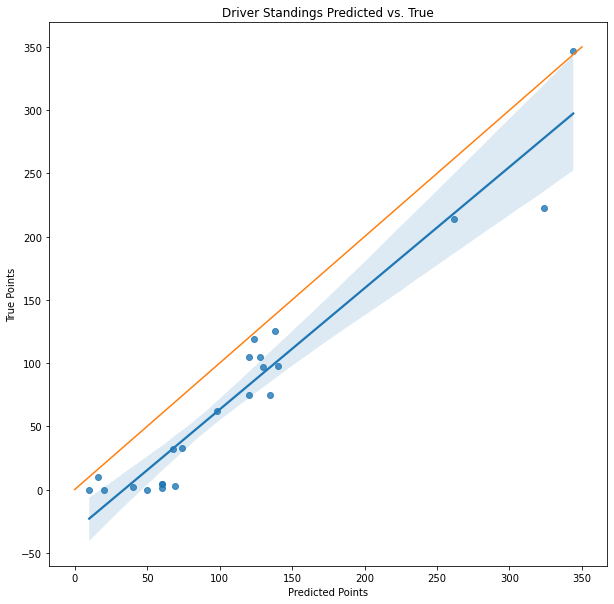

In [22]:
plt.subplots(figsize=(10, 10))
sns.regplot(data=driver_correlation_comparison, x='pred_points', y='true_points')
plt.plot([y_test.min(), 350], [y_test.min(), 350])
plt.title('Driver Standings Predicted vs. True')
plt.xlabel('Predicted Points')
plt.ylabel('True Points')

# Constructor Standings

In [23]:
final_constructors

,constructor,pred_points,true_points,pred_positions,true_positions
0,mercedes,625,573,1,1
1,red_bull,325,319,2,2
2,racing_point,225,195,3,4
3,renault,155,181,4,5
4,mclaren,151,202,5,3
5,ferrari,114,131,6,6
6,alphatauri,78,107,7,7
7,alfa,30,8,8,8
8,haas,8,3,9,9
9,williams,6,0,10,10


In [28]:
constructors

{'spearman': 0.9636,
 'pearson': 0.9883,
 'r2': 0.9687,
 'mse': 859.2,
 'rmse': 29.312}

Text(0, 0.5, 'True Points')

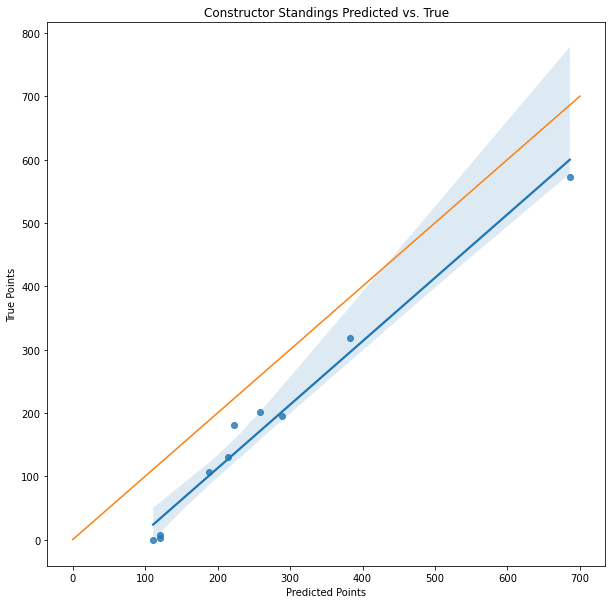

In [24]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.regplot(data=correlation_comparison, x='pred_points', y='true_points')
x_label=('Predicted Points')
plt.plot([y_test.min(), 700], [y_test.min(), 700])
plt.title('Constructor Standings Predicted vs. True')
plt.xlabel('Predicted Points')
plt.ylabel('True Points')

In [29]:
# Save the model

joblib.dump(pipe, 'ignore/models/f1model_RFR.pkl')

['ignore/models/f1model_RFR.pkl']

In [26]:
# Load the saved model

# pipe = joblib.load('ignore/models/f1model_RFR.pkl')